# Descrizione
Qui carico le epoche che ho ricavato dall'aggregazione dell'informazione di una stessa roi con il metodo utilizzato in roi_proc_step1.<br>
* Plotto i dati su ROI su corteccia per varie viste.<br>
* Faccio un subplot con ROI di riferimento per ogni vista utile. <br>

Genero questi plot:

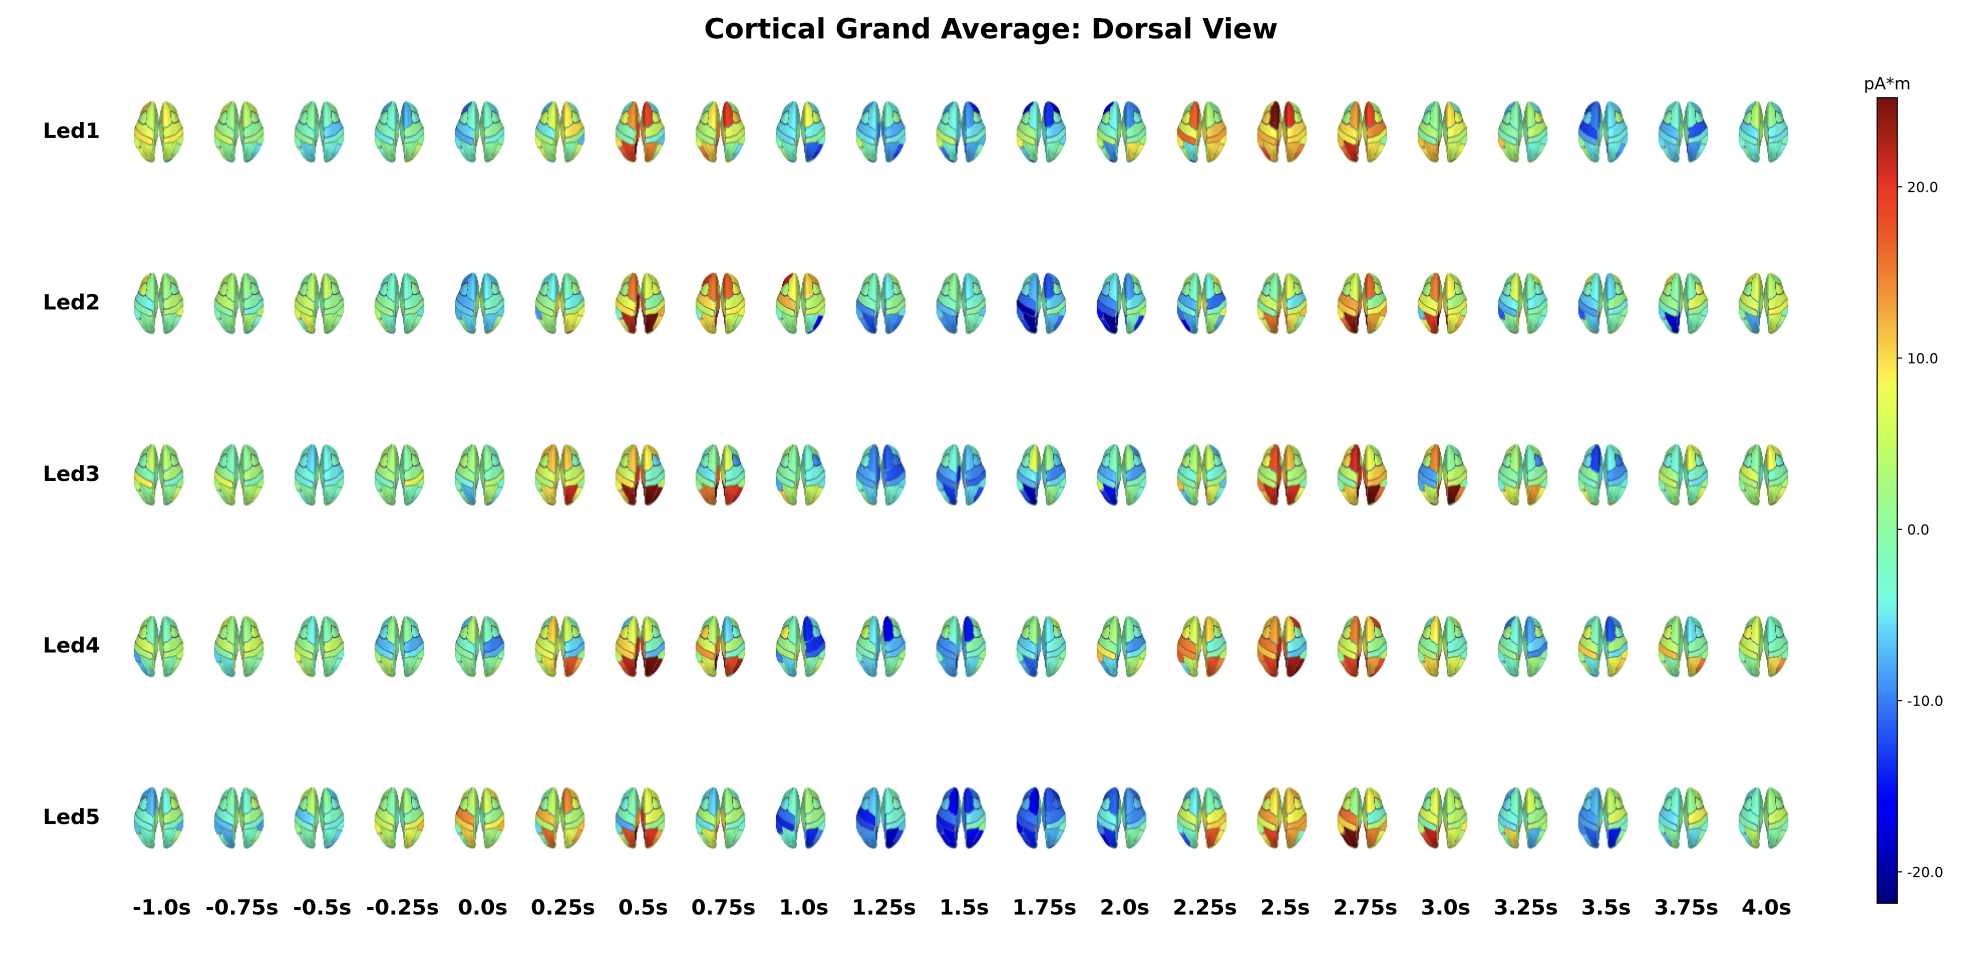

In [11]:
import os
import numpy as np
import nibabel as nib
from surfer import Brain
import mne
import glob
import pickle
from scipy.signal import ellip, ellipord, filtfilt
import matplotlib.pyplot as plt
import cv2
from mne.source_space import label_src_vertno_sel
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs

In [12]:
def select_subjects(path):
    """
    Pick up all the valid subjects path.
    :param path: path to the folder containing the experiment directories
    :return: list of all subject paths
    """
    sbjs = []
    experiments_path = sorted(glob.glob(os.path.join(path, 'experiment*')))
    for ep in experiments_path:
        if os.path.basename(ep) == 'experiment1':
            sbjs.append(sorted(glob.glob(os.path.join(ep, 'sub*')))[1:])
        else:
            sbjs.append(sorted(glob.glob(os.path.join(ep, 'sub*')))[1:])
    sbjs = sorted([s for l in sbjs for s in l])
    return sbjs

# Carico i dati e faccio il grand average

In [13]:
# Prendo le epoche ricavate da pca_sk
root_path = '/Users/federico/University/Magistrale/00.TESI/data_original'
sbj_paths = select_subjects(path=root_path)
date_folder = '2022_10_15_21_35' #'2022_10_12_21_19'
relative_path = os.path.join('data_preproc3', 'sources', date_folder)
print(sbj_paths)

['/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-002', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-003', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-004', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-005', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-006', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-007', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-008', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-009', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-010', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment1/sub-002', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment1/sub-003', '/Users/federico/University/Magistrale/00.TESI/data_original/experiment1/sub-004', '/U

In [14]:
# Faccio il grand average
# Dichiaro un array dove conterrò tutte le epoche
# Dichiaro un array dove conterrà tutti i targets
all_epochs = []
all_targets = []

for sub_path in sbj_paths:
    print(sub_path)
    
    # File che contiene le epoche:
    file_path = os.path.join(sub_path, relative_path, 'source_signal.pkl')
    
    # Carico il dizionario con le epoche:
    with open(file_path, 'rb') as f:
        m_dict = pickle.load(f)
    
    # Carico i campi del dizionario in delle variabili:
    epochs = m_dict['epochs']
    roi_df = m_dict['roi_df']
    targets = m_dict['targets']
    roi_names = roi_df['roi_names'].tolist()
    srate = 512
    pre_time = m_dict['pre_time']
    post_time = m_dict['post_time']
    
    all_epochs.append(epochs)
    all_targets.append(targets)
    
all_epochs = np.concatenate(all_epochs)
all_targets = np.concatenate(all_targets)

print(f"all_epochs.shape:  {all_epochs.shape}")
print(f"all_targets.shape: {all_targets.shape}")

/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-002
/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-003
/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-004
/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-005
/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-006
/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-007
/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-008
/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-009
/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/sub-010
/Users/federico/University/Magistrale/00.TESI/data_original/experiment1/sub-002
/Users/federico/University/Magistrale/00.TESI/data_original/experiment1/sub-003
/Users/federico/University/Magistrale/00.TESI/data_original/experiment1/sub-004
/Users/federico/University/Magistrale/00

In [15]:
# Dichiaro i parametri del filtro
# Passa basso
srate = 512
wp = 10 / (srate / 2)
ws = 15 / (srate / 2)
gpass = 0.1
gstop = 40
ord, wn = ellipord(wp, ws, gpass, gstop)
b_lp, a_lp = ellip(ord, gpass, gstop, wn, btype='low')

# Passa alto
srate = 512
wp = 0.5 / (srate / 2)
ws = 0.01 / (srate / 2)
gpass = 0.1
gstop = 40
ord, wn = ellipord(wp, ws, gpass, gstop)
b_hp, a_hp = ellip(ord, gpass, gstop, wn, btype='high')

In [16]:
# Filtro i dati e rimuovo la baseline filtrata
n_epochs, n_channels, n_time_sample = all_epochs.shape
epochs_filt = np.zeros((n_epochs, n_channels, n_time_sample))
for j, epoch_ in enumerate(all_epochs):
    epoch_lp = filtfilt(b_lp, a_lp, epoch_)
    epoch = filtfilt(b_hp, a_hp, epoch_lp)
    baseline = np.mean(epoch[:, :512], axis=-1)
    baseline = baseline.reshape(n_channels, 1)
    epochs_filt[j, : , :] = epoch - baseline
print(f"epoch_filt.shape: {epochs_filt.shape}")

epoch_filt.shape: (6150, 68, 2560)


In [17]:
# Faccio il grand average
n_epochs, n_channels, n_time_sample = all_epochs.shape
n_unique_targets = np.unique(all_targets).shape[0]
grand_average = np.zeros((n_unique_targets, n_channels, n_time_sample))
for j, target in enumerate(np.unique(all_targets)):
    grand_average[j, : , :] = np.mean(epochs_filt[all_targets == target, :, :], axis=0)

In [18]:
# Stampiamo alcune info utili su grand average
fmin = np.min(grand_average)
fmax = np.max(grand_average)
fmin = fmin - 0.2*fmin # - 0.25 * fmin
fmax = fmax - 0.6 * fmax
if np.abs(fmin) < np.abs(fmax):
    fmin = -fmax
else:
    fmax = -fmin
        
print(f"MAX grand_average: {fmax}")
print(f"MIN grand_average: {fmin}")

MAX grand_average: 2.5201060779130174e-11
MIN grand_average: -2.5201060779130174e-11


# Plotto su ROI

In [28]:
# Definisci il cervello del soggetto medio e i labels
subject_id = "fsaverage"
subjects_dir = mne.datasets.sample.data_path() / 'subjects'

labels_name = 'aparc'
labels = mne.read_labels_from_annot('fsaverage', labels_name)
labels = [label for label in labels if 'unknown' not in label.name]

# Per ogni istante di tempo devi fare un plot per ogni label
# Declaring plotting parameters
n_time_sample = grand_average.shape[-1]
print(f"n_time_sample: {n_time_sample}")
nsample = int(n_time_sample / 512 * 4 + 1)
samples = np.linspace(0, n_time_sample, nsample)
samples[1:] = samples[1:] - 1
samples = samples.astype(int)
print(samples)

Reading labels from parcellation...
   read 35 labels from /Users/federico/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/federico/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
n_time_sample: 2560
[   0  127  255  383  511  639  767  895 1023 1151 1279 1407 1535 1663
 1791 1919 2047 2175 2303 2431 2559]


**Definisci che vista vuoi avere del cervello**

In [29]:
hemi = 'both'
surf = 'inflated'
views = 'dorsal'
window = 0.25
# Define save path & save image to path
save_path = '/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250'

Uso l'altas di MNE, stesso che ho usato per generare le ROI. <br>
Uso anche brain.annot per separare le roi

In [30]:
Brain = mne.viz.get_brain_class()
brain = Brain(subject_id=subject_id,
              hemi=hemi,
              surf=surf,
              subjects_dir=subjects_dir,
              background='white',
              views=views,
              offscreen=True)
print(hemi)

# Calcolo il gran average in una finestra temporale
for c, ga in enumerate(grand_average):
    for ss, s in enumerate(samples):

        # Mean of grand average around sample s
        if s == samples[0]:
            start = s
            stop = s + int(window * srate)
        elif s == samples[-1]:
            start = s - int(window * srate)
            stop = s
        else:
            start = s - int(window * 0.5 * srate)
            stop = s + int(window * 0.5 * srate)
        
        temp_ga = np.mean(ga[:, start:stop], axis=1)

        data_lh = np.zeros(163842)
        data_rh = np.zeros(163842)
        for i in range(68):
            if labels[i].hemi == 'lh':
                data_lh[labels[i].vertices] = temp_ga[i]
            if labels[i].hemi == 'rh':
                data_rh[labels[i].vertices] = temp_ga[i]
        
        if hemi == 'both':
            brain.add_data(data_lh, 
                           fmin=fmin,
                           fmax=fmax, 
                           hemi='lh',
                           alpha=1, 
                           colormap='jet',
                           colorbar=False)

            brain.add_data(data_rh,
                           fmin=fmin,
                           fmax=fmax,
                           hemi='rh', 
                           alpha=1, 
                           colormap='jet',
                           colorbar=False)

            brain.add_annotation("aparc")
        
        elif hemi == 'lh':
            brain.add_data(data_lh, 
                           fmin=fmin,
                           fmax=fmax, 
                           hemi=hemi,
                           alpha=1, 
                           colormap='jet',
                           colorbar=False)
            
            brain.add_annotation("aparc")
            
        elif hemi == 'rh':
            brain.add_data(data_rh, 
                           fmin=fmin,
                           fmax=fmax, 
                           hemi=hemi,
                           alpha=1, 
                           colormap='jet',
                           colorbar=False)
            
            brain.add_annotation("aparc")


        
        # Define save path & save image to path
        if ss < 10:
            path = os.path.join(save_path, f'activation_led{c}_sample_00{ss}.jpg')
        elif ss >= 10:
            path = os.path.join(save_path, f'activation_led{c}_sample_0{ss}.jpg')
        brain.save_image(path)
        
        #brain.close()

both


/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led0_sample_000.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led0_sample_001.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led0_sample_002.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led0_sample_003.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led0_sample_004.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led0_sample_005.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led0_sample_006.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led0_sample_007.jpg
/Users/federico/University/Magis

/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led3_sample_006.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led3_sample_007.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led3_sample_008.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led3_sample_009.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led3_sample_010.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led3_sample_011.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led3_sample_012.jpg
/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/roi_v250/activation_led3_sample_013.jpg
/Users/federico/University/Magis

/var/folders/7d/lq2mc9b14zqfhkq7xy8v8f1h0000gr/T/ipykernel_8719/562538360.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(ticks*1e12, 2))
/var/folders/7d/lq2mc9b14zqfhkq7xy8v8f1h0000gr/T/ipykernel_8719/562538360.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


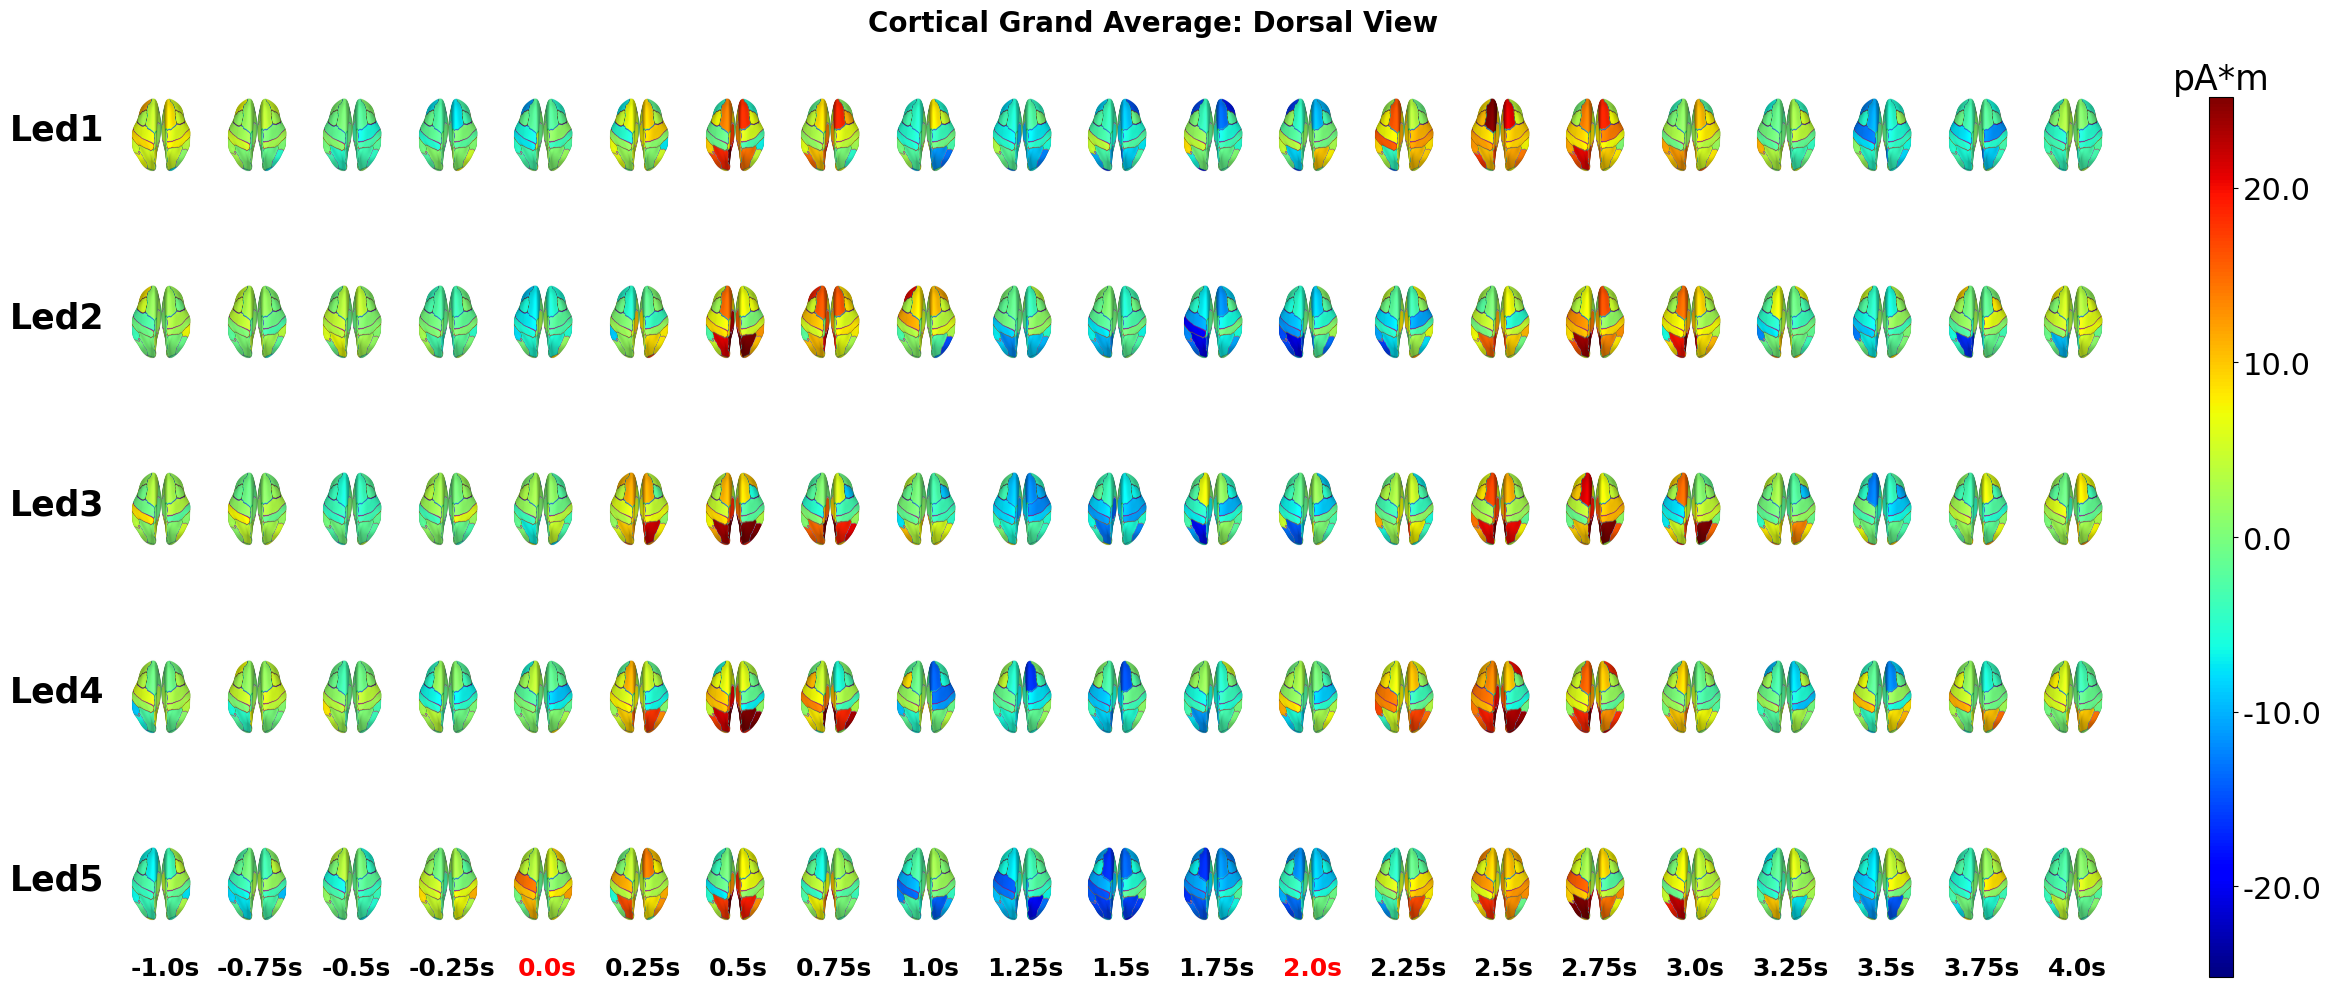

In [31]:
# Load images path
imgs_path = sorted(glob.glob(os.path.join(save_path, 'activation*')))

# Title LOGIC
if views == 'medial' and hemi == 'lh':
    title = 'Cortical Grand Average: Medial View, Left Hemisphere'
elif views == 'medial' and hemi == 'rh':
    title = 'Cortical Grand Average: Medial View, Right Hemisphere'
elif views == 'lateral' and hemi == 'lh':
    title = 'Cortical Grand Average: Lateral View, Left Hemisphere'
elif views == 'lateral' and hemi == 'rh':
    title = 'Cortical Grand Average: Lateral View, Right Hemisphere'
elif views == 'dorsal' and hemi == 'both':
    title = 'Cortical Grand Average: Dorsal View'
elif views == 'caudal' and hemi == 'both':
    title = f'Cortical Grand Average: {views.capitalize()} View'
elif views == 'rostral' and hemi == 'both':
    title = f'Cortical Grand Average: {views.capitalize()} View'

# # Initialize figure
fig, axs = plt.subplots(5, nsample, figsize=(24, 11))
fig.suptitle(title, fontsize=20, fontweight='bold')
# fig, axs = plt.subplots(1, nsample, figsize=(20, 10))
# fig.suptitle(title, fontsize=20, fontweight='bold')

# Define colorbar
colormap = plt.cm.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=colormap)
vmin = fmin
vmax = fmax
sm.set_clim(vmin=vmin, vmax=vmax)

# Create the cortical grand average figure
for img_path, ax in zip(imgs_path, axs.ravel()):
    print(img_path)
    im = plt.imread(img_path)
    os.remove(img_path)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Define x_labels and y_labels
cols = ['{}s'.format(col) for col in np.arange(-1, 4.25, 0.25)]
rows = ['Led{}'.format(row) for row in [1, 2, 3, 4, 5]]

# for ax, col in zip(axs, cols):
#     ax.set_xlabel(col, fontweight='bold', fontsize=15)
#     ax.xaxis.set_label_coords(0.55, -0.7)

# Add seconds to the bottom of the figure (x_label)
for ax, col in zip(axs[-1], cols):
    if col == '0.0s' or col == '2.0s':
        ax.set_xlabel(col, fontweight='bold', fontsize=18, color='red')
        ax.xaxis.set_label_coords(0.55, -0.4)
    else:
        ax.set_xlabel(col, fontweight='bold', fontsize=18)
        ax.xaxis.set_label_coords(0.55, -0.4)
# Add LED id to left of figure (y_labels)
for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, fontweight='bold', fontsize=25, rotation=0)
    ax.yaxis.set_label_coords(-0.8, 0.35)

# Adding a big colorbar to the side of the figure
cbar_ax = fig.add_axes([0.94, 0.1, 0.01, 0.8])
cb = fig.colorbar(sm, cax=cbar_ax)
cb.ax.tick_params(labelsize=22)
ticks = cb.get_ticks()
cb.ax.set_yticklabels(np.round(ticks*1e12, 2))
cb.ax.set_title('pA*m', fontsize=25)

# Adjusting subplot distances and location inside the figure
fig.subplots_adjust(left=0.07,
                    bottom=0.1,
                    right=0.90,
                    top=0.95,
                    wspace=0.2,
                    hspace=0.01)
fig.show()
path = os.path.join(save_path, 'CORTICAL_GA-' + views + '_' + hemi + '.pdf')
fig.savefig(path)

# PLOT delle roi di interesse come riferimento

Reading labels from parcellation...
   read 35 labels from /Users/federico/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/federico/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
[<Label | fsaverage, 'cuneus-lh', lh : 1630 vertices>, <Label | fsaverage, 'cuneus-rh', rh : 1638 vertices>, <Label | fsaverage, 'precuneus-lh', lh : 7308 vertices>, <Label | fsaverage, 'precuneus-rh', rh : 7975 vertices>]
Using pyvistaqt 3d backend.

[<Label | fsaverage, 'cuneus-lh', lh : 1630 vertices>, <Label | fsaverage, 'cuneus-rh', rh : 1638 vertices>, <Label | fsaverage, 'precuneus-lh', lh : 7308 vertices>, <Label | fsaverage, 'precuneus-rh', rh : 7975 vertices>]
[<Label | fsaverage, 'cuneus-lh', lh : 1630 vertices>, <Label | fsaverage, 'cuneus-rh', rh : 1638 vertices>, <Label | fsaverage, 'precuneus-lh', lh : 7308 vertices>, <Label | fsaverage, 'precuneus-rh', rh : 7975 vertices>]
[<Label | fsaverage, 'cuneus-lh', lh : 1630 vertices>, <Label | fsaver

Context leak detected, msgtracer returned -1


[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>]
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>]
[<Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
[<Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
[<Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
[<Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
[<Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
[<Label | fsaverage, 'precuneus-lh', lh : 7308 vertices>, <Label | fsaverage, 'precuneus-rh', rh : 7975 vertices>]
[<Label | fsaverage, 'precuneus-lh', lh : 7308 verti

Context leak detected, msgtracer returned -1


[<Label | fsaverage, 'precuneus-lh', lh : 7308 vertices>, <Label | fsaverage, 'precuneus-rh', rh : 7975 vertices>]
[<Label | fsaverage, 'precuneus-lh', lh : 7308 vertices>, <Label | fsaverage, 'precuneus-rh', rh : 7975 vertices>]
[<Label | fsaverage, 'precuneus-lh', lh : 7308 vertices>, <Label | fsaverage, 'precuneus-rh', rh : 7975 vertices>]
[<Label | fsaverage, 'superiorfrontal-lh', lh : 12179 vertices>, <Label | fsaverage, 'superiorfrontal-rh', rh : 11878 vertices>]
[<Label | fsaverage, 'superiorfrontal-lh', lh : 12179 vertices>, <Label | fsaverage, 'superiorfrontal-rh', rh : 11878 vertices>]
[<Label | fsaverage, 'superiorfrontal-lh', lh : 12179 vertices>, <Label | fsaverage, 'superiorfrontal-rh', rh : 11878 vertices>]
[<Label | fsaverage, 'superiorfrontal-lh', lh : 12179 vertices>, <Label | fsaverage, 'superiorfrontal-rh', rh : 11878 vertices>]
[<Label | fsaverage, 'superiorfrontal-lh', lh : 12179 vertices>, <Label | fsaverage, 'superiorfrontal-rh', rh : 11878 vertices>]
[<Label | 

Context leak detected, msgtracer returned -1


[<Label | fsaverage, 'superiorparietal-lh', lh : 10456 vertices>, <Label | fsaverage, 'superiorparietal-rh', rh : 10222 vertices>]
[<Label | fsaverage, 'superiorparietal-lh', lh : 10456 vertices>, <Label | fsaverage, 'superiorparietal-rh', rh : 10222 vertices>]
[<Label | fsaverage, 'superiorparietal-lh', lh : 10456 vertices>, <Label | fsaverage, 'superiorparietal-rh', rh : 10222 vertices>]
[<Label | fsaverage, 'superiorparietal-lh', lh : 10456 vertices>, <Label | fsaverage, 'superiorparietal-rh', rh : 10222 vertices>]


/var/folders/7d/lq2mc9b14zqfhkq7xy8v8f1h0000gr/T/ipykernel_65948/2872719149.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


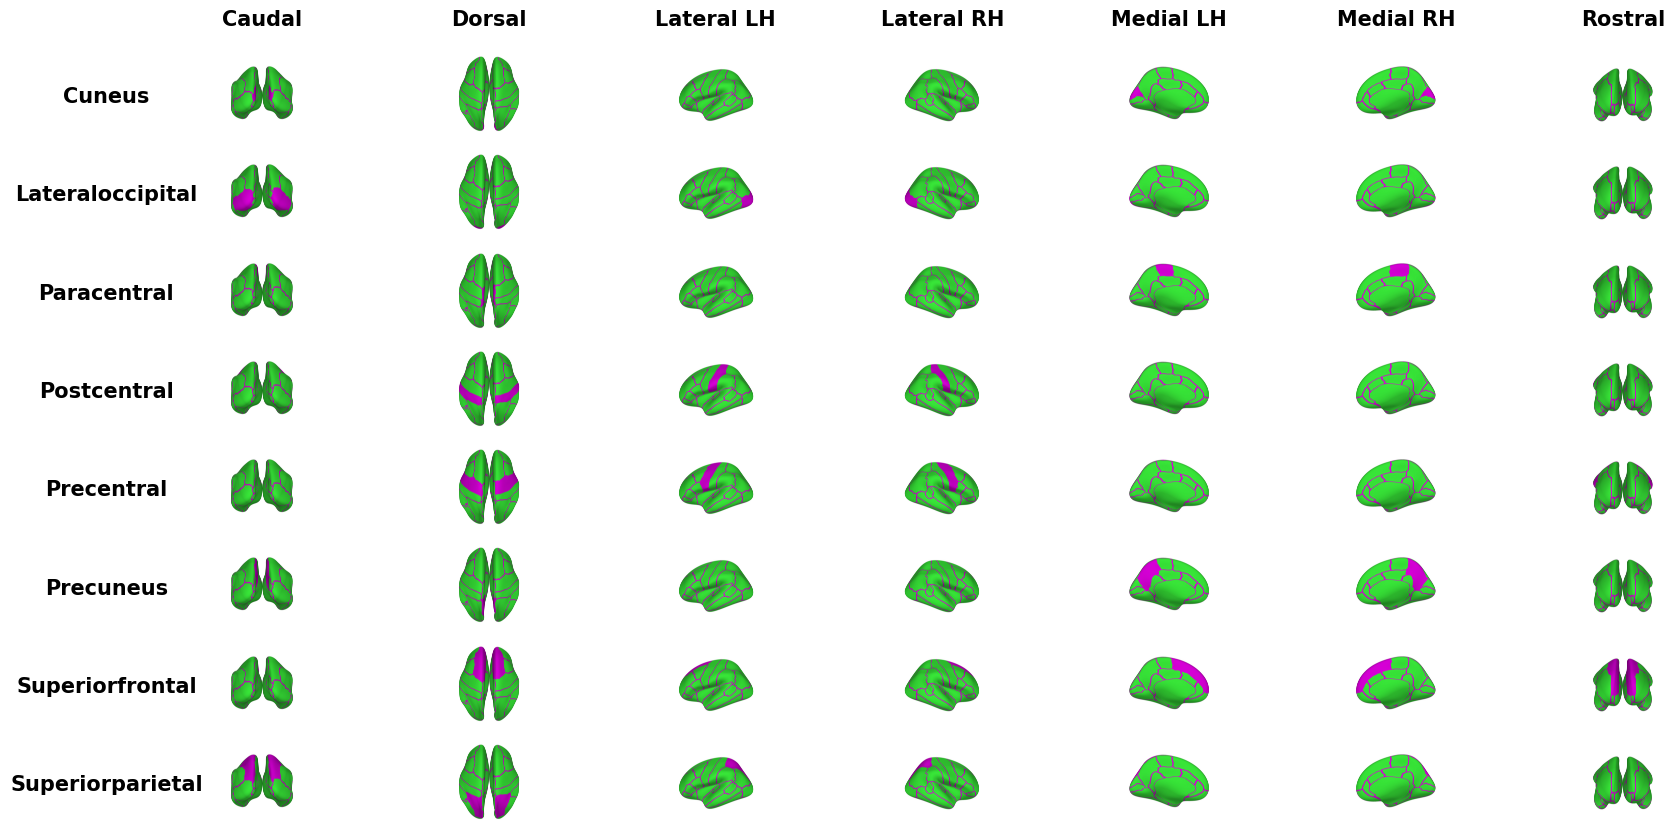

In [3]:
# Picking up labels
subjects_dir = mne.datasets.sample.data_path() / 'subjects'
surf = 'inflated'
subject_id = 'fsaverage'
labels_name = 'aparc'
labels = mne.read_labels_from_annot(subject_id, labels_name)
labels = [label for label in labels if 'unknown' not in label.name]
# # List of ROIs of interest names
# labels_of_interest = ['paracentral-lh', 'paracentral-rh',
#                       'postcentral-lh', 'postcentral-rh',
#                       'precentral-lh', 'precentral-rh',
#                       'superiorparietal-lh', 'superiorparietal-rh',
#                       'inferiorparietal-lh', 'inferiorparietal-rh',
#                       'lateraloccipital-lh', 'lateraloccipital-rh']
labels_of_interest = ['cuneus',
                      'lateraloccipital',
                      'paracentral',
                      'postcentral',
                      'precentral',
                      'precuneus',
                      'superiorfrontal',
                      'superiorparietal']
# List of views
views = ['dorsal', 'caudal', 'medial', 'lateral', 'rostral']

# Save_path
save_path = '/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/reference_v1'

already_saved = False
if not already_saved:
    for label in labels_of_interest:
        for view in views:
            # Declaring Brain Class
            Brain = mne.viz.get_brain_class()
            label_to_plot = [l for l in labels if label in l.name]
            print(label_to_plot)
            if view == 'dorsal' or view == 'caudal' or view == 'rostral':
                # Selecting Label object based on labels_of_interest names
                hemi = 'both'
                brain = Brain(subject_id=subject_id,
                              hemi=hemi,
                              surf=surf,
                              subjects_dir=subjects_dir,
                              background='white',
                              views=view,
                              cortex='limegreen',
                              alpha=1)
                brain.add_label(label=label_to_plot[0], hemi='lh', color='m')
                brain.add_label(label=label_to_plot[1], hemi='rh', color='m')
                brain.add_annotation('aparc', color='m')
                path = os.path.join(save_path, label + '_' + view + '.jpg')
                brain.save_image(path)
                brain.close()
            else:
                for hemi in ['lh', 'rh']:
                    if hemi == 'lh':
                        brain = Brain(subject_id=subject_id,
                                      hemi=hemi,
                                      surf=surf,
                                      subjects_dir=subjects_dir,
                                      background='white',
                                      views=view,
                                      cortex='limegreen',
                                      alpha=1)
                        brain.add_label(label=label_to_plot[0], hemi=hemi, color='m')
                        brain.add_annotation('aparc', color='m')
                        path = os.path.join(save_path, label + '_' + view + '_' + hemi + '.jpg')
                        brain.save_image(path)
                        brain.close()
                    if hemi == 'rh':
                        brain = Brain(subject_id=subject_id,
                                      hemi=hemi,
                                      surf=surf,
                                      subjects_dir=subjects_dir,
                                      background='white',
                                      views=view,
                                      cortex='limegreen',
                                      alpha=1)
                        brain.add_label(label=label_to_plot[1], hemi=hemi, color='m')
                        brain.add_annotation('aparc', color='m')
                        path = os.path.join(save_path, label + '_' + view + '_' + hemi + '.jpg')
                        brain.save_image(path)
                        brain.close()

load_path = save_path
imgs_path = sorted(glob.glob(os.path.join(save_path, '*.jpg')))
col_names = ['Caudal', 'Dorsal', 'Lateral LH', 'Lateral RH', 'Medial LH', 'Medial RH', 'Rostral']

fig, axs = plt.subplots(nrows=len(labels_of_interest), ncols=len(col_names), figsize=(20, 10))
for img, ax in zip(imgs_path, axs.ravel()):
    im = plt.imread(img)
    os.remove(img)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
for ax, col in zip(axs[0], col_names):
    ax.set_title(col, fontweight='bold', fontsize=15, pad=20)
for ax, label in zip(axs[:, 0], sorted(labels_of_interest)):
    ax.set_ylabel(label.capitalize(), fontweight='bold', fontsize=15, rotation=0)
    ax.yaxis.set_label_coords(-1.4, 0.35)
fig.show()
path = os.path.join(save_path, 'reference_imagev1.pdf')
fig.savefig(path)

In [3]:
labels

[<Label | fsaverage, 'bankssts-lh', lh : 2137 vertices>,
 <Label | fsaverage, 'bankssts-rh', rh : 2196 vertices>,
 <Label | fsaverage, 'caudalanteriorcingulate-lh', lh : 1439 vertices>,
 <Label | fsaverage, 'caudalanteriorcingulate-rh', rh : 1608 vertices>,
 <Label | fsaverage, 'caudalmiddlefrontal-lh', lh : 3736 vertices>,
 <Label | fsaverage, 'caudalmiddlefrontal-rh', rh : 3494 vertices>,
 <Label | fsaverage, 'cuneus-lh', lh : 1630 vertices>,
 <Label | fsaverage, 'cuneus-rh', rh : 1638 vertices>,
 <Label | fsaverage, 'entorhinal-lh', lh : 1102 vertices>,
 <Label | fsaverage, 'entorhinal-rh', rh : 902 vertices>,
 <Label | fsaverage, 'frontalpole-lh', lh : 272 vertices>,
 <Label | fsaverage, 'frontalpole-rh', rh : 369 vertices>,
 <Label | fsaverage, 'fusiform-lh', lh : 4714 vertices>,
 <Label | fsaverage, 'fusiform-rh', rh : 4661 vertices>,
 <Label | fsaverage, 'inferiorparietal-lh', lh : 7871 vertices>,
 <Label | fsaverage, 'inferiorparietal-rh', rh : 9676 vertices>,
 <Label | fsavera